In [1]:
import os
from pathlib import Path, PurePath
import pandas as pd
import numpy as np
import cv2
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
input_folder = Path("/Volumes/Data1/Projets/Blood_cells/Data/Munich/")


In [3]:
file_list = [x for x in input_folder.glob(
    '**/*.tiff') if x.is_file() and not x.name.startswith('.')]
print(len(file_list), ".tiff files in input_folder")
file_list[-1]


18365 .tiff files in input_folder


PosixPath('/Volumes/Data1/Projets/Blood_cells/Data/Munich/AML/PMB/PMB_0012.tiff')

In [4]:
def photo_parser(photo_path):
    """
    Parse a photo_path and identify photo attributes as:
    cell_type : str, name of directory ex: basophil, eosinophil, ....
    cell_code : str, prefix of file ex: BA, EO, ERB, .....
    Photo_id : str, id of photo file
    Photo_path : PosixPath
    Return values in a dict
    """
    path_list = str(photo_path).split("/")  # list
    cell_type = str(photo_path).split("/")[-2]
    cell_code = list(filter(lambda v: re.match(
        '.*tiff', v), path_list))[0].split('_')[0]
    Photo_id = list(filter(lambda v: re.match(
        '.*tiff', v), path_list))[0].split('.')[0]
    d = {
        'Cell_type': cell_type,
        'Cell_code': cell_code,
        'Photo_id': Photo_id,
        'Photo_path': photo_path
    }
    return d


In [5]:
i = 0
total_to_import = len(file_list)
dataset = []
for photo_path in file_list:
    photo = photo_parser(photo_path)
    dataset.append(photo)
    i += 1

print(f'{i} photos imported over {total_to_import} ({round(100*i/total_to_import, 2)} %) photos in {input_folder}')
# Import du dataset dans une DF
df = pd.DataFrame(dataset)


18365 photos imported over 18365 (100.0 %) photos in /Volumes/Data1/Projets/Blood_cells/Data/Munich


In [6]:
print(df.shape)
df.head()


(18365, 4)


,Cell_type,Cell_code,Photo_id,Photo_path
0,KSC,KSC,KSC_0005,/Volumes/Data1/Projets/Blood_cells/Data/Munich...
1,KSC,KSC,KSC_0013,/Volumes/Data1/Projets/Blood_cells/Data/Munich...
2,KSC,KSC,KSC_0009,/Volumes/Data1/Projets/Blood_cells/Data/Munich...
3,KSC,KSC,KSC_0008,/Volumes/Data1/Projets/Blood_cells/Data/Munich...
4,KSC,KSC,KSC_0012,/Volumes/Data1/Projets/Blood_cells/Data/Munich...


In [7]:
df.isna().any()


Cell_type     False
Cell_code     False
Photo_id      False
Photo_path    False
dtype: bool

In [16]:
def images_stats(photo_path):
    """
    Load an image from photo_path and compute :
    H : Height of the image
    W: Width of the image
    'col'_max : max value of channel 'col'
    'col'_min : min value of chenel 'col
    'col'_mean : mean value of chanel 'col'
    """
    #print(photo_path)
    img = cv2.imread(str(photo_path), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #plt.imshow(img);
    
    d = {}
    for i in range(2):
        d[str('H')] = img.shape[0]
        d[str('W')] = img.shape[1]

    colors = ['red', 'green', 'blue']
    for i, col in enumerate(colors):
        d[str(col + '_' + 'max')] = np.max(img[:,:,i])
        d[str(col + '_' + 'min')] = np.min(img[:,:,i])
        d[str(col + '_' + 'mean')] = np.mean(img[:,:,i])
        #d[str(col + '_' + 'hist')] = cv2.calcHist(img,[i],None,[256],[0,256])

    return d

In [18]:
stats_df = df['Photo_path'].apply(lambda x: pd.Series(images_stats(x)))

In [19]:
stats_df.head()

,H,W,red_max,red_min,red_mean,green_max,green_min,green_mean,blue_max,blue_min,blue_mean
0,400.0,400.0,245.0,146.0,214.727881,234.0,75.0,189.396337,242.0,156.0,215.046687
1,400.0,400.0,255.0,66.0,216.410119,255.0,0.0,195.812294,255.0,146.0,216.926956
2,400.0,400.0,189.0,75.0,148.419138,183.0,0.0,128.504750,184.0,112.0,151.969419
3,400.0,400.0,255.0,56.0,227.528787,255.0,0.0,212.622212,255.0,159.0,232.660262
4,400.0,400.0,255.0,149.0,228.507088,253.0,46.0,201.290400,255.0,189.0,232.673450


In [20]:
Munich = pd.concat([df, stats_df], axis=1)
print(Munich.shape)
Munich.head()

(18365, 15)


,Cell_type,Cell_code,Photo_id,Photo_path,H,W,red_max,red_min,red_mean,green_max,green_min,green_mean,blue_max,blue_min,blue_mean
0,KSC,KSC,KSC_0005,/Volumes/Data1/Projets/Blood_cells/Data/Munich...,400.0,400.0,245.0,146.0,214.727881,234.0,75.0,189.396337,242.0,156.0,215.046687
1,KSC,KSC,KSC_0013,/Volumes/Data1/Projets/Blood_cells/Data/Munich...,400.0,400.0,255.0,66.0,216.410119,255.0,0.0,195.812294,255.0,146.0,216.926956
2,KSC,KSC,KSC_0009,/Volumes/Data1/Projets/Blood_cells/Data/Munich...,400.0,400.0,189.0,75.0,148.419138,183.0,0.0,128.504750,184.0,112.0,151.969419
3,KSC,KSC,KSC_0008,/Volumes/Data1/Projets/Blood_cells/Data/Munich...,400.0,400.0,255.0,56.0,227.528787,255.0,0.0,212.622212,255.0,159.0,232.660262
4,KSC,KSC,KSC_0012,/Volumes/Data1/Projets/Blood_cells/Data/Munich...,400.0,400.0,255.0,149.0,228.507088,253.0,46.0,201.290400,255.0,189.0,232.673450


Write csv file

In [22]:
Munich.to_csv(Path(input_folder/'Munich.csv'), index=False)

## Séparation du jeu de données Munich en 15 classes et conversion en png

In [8]:
input_folder = Path("/Volumes/Data1/Projets/Blood_cells/Data/Munich")
output_folder = Path("/Volumes/Data1/Projets/Blood_cells/Data/Munich_11cat")

output_folder.mkdir(exist_ok=True)

for file in input_folder.glob('**/*.tiff'):
    if file.is_file() and not file.name.startswith('.'):
        # Include only identified blood cells
        tag = file.parts[-1].split('_')[0]
        file_name = file.parts[-1].split('.')[0]

        # Elimination des LYA, lymphocytes atypiques
        # PMB
        # PMO
        if tag not in ['LYA', 'PMB', 'PMO', 'MYB']:
            # read image
            image = cv2.imread(str(file), cv2.IMREAD_COLOR)
            Path(output_folder / tag).mkdir(exist_ok=True)
            save_path = Path(output_folder / tag /
                             str(str(file_name) + '.png'))
            # Convert the image in png and save
            cv2.imwrite(str(save_path), image)


### Renomage des dossiers avec les catégories équivalentes à PBC

Abbreviations of morphological classes used in folder structure and annotation file
----------------------------------------------------------------------------------------
- BAS Basophil
- EBO Erythroblast
- EOS Eosinophil
- KSC Smudge cell
- LYA Lymphocyte (atypical)
- LYT Lymphocyte (typical)
- MMZ Metamyelocyte
- MOB Monoblast
- MON Monocyte
- MYB Myelocyte
- MYO Myeloblast
- NGB Neutrophil (band)
- NGS Neutrophil (segmented)
- PMB Promyelocyte (bilobled)
- PMO Promyelocyte

UNC Image that could not be assigned a class during re-annotation
nan no re-annotation

In [9]:
renommer_dossiers = {
    # Munich : PBC
    'BAS': 'BA',
    'EBO': 'ERB',
    'EOS': 'EO',
    'KSC': 'SMU',
    'LYT': 'LY',
    'MMZ': 'MMY',
    'MOB': 'PMY',
    'MON': 'MO',
    'MYO': 'MYO',
    'NGB': 'BNE',
    'NGS': 'SNE',
}
dossier_parent = Path("/Volumes/Data1/Projets/Blood_cells/Data/Munich_11cat")
for dossier in dossier_parent.iterdir():
    if dossier.is_dir() and dossier.name in renommer_dossiers:
        nouveau_nom = renommer_dossiers[dossier.name]
        nouveau_chemin = dossier_parent / nouveau_nom
        dossier.rename(nouveau_chemin)


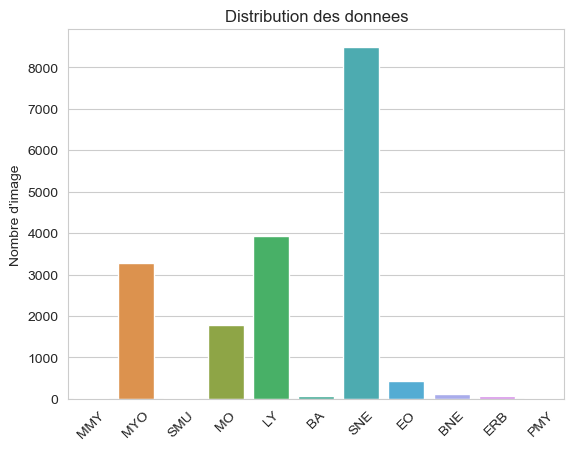

In [10]:
path = Path("/Volumes/Data1/Projets/Blood_cells/Data/Munich_11cat")

subdirs = [name for name in os.listdir(
    path) if os.path.isdir(os.path.join(path, name))]

# Count the number of files in each subdirectory
file_counts = [len(os.listdir(os.path.join(path, subdir)))
               for subdir in subdirs]

sns.set_style("whitegrid")
sns.barplot(x=subdirs, y=file_counts)
plt.ylabel("Nombre d'image")
plt.title("Distribution des donnees")
plt.xticks(rotation=45)
plt.show()


## Création d'un échantillon

In [11]:
import random
import shutil
sample_length = 5

input_folder = Path("/Volumes/Data1/Projets/Blood_cells/Data/Munich_11cat")
output_folder = Path("../Data/Munich_sample")

output_folder.mkdir(exist_ok=True)

for subdir in input_folder.iterdir():
    if subdir.is_dir():
        # print(subdir)
        tag = subdir.parts[-1]
        files = [i for i in subdir.glob('**/*.png') if i.is_file()]
        sample = random.sample(files, sample_length)

        # copy sample in output folder
        for file in sample:
            # print(file)
            tag_folder = output_folder/tag
            # print(tag_folder)
            tag_folder.mkdir(exist_ok=True)
            file_name = file.parts[-1]
            # print(file_name)
            shutil.copy(file, tag_folder/file_name)


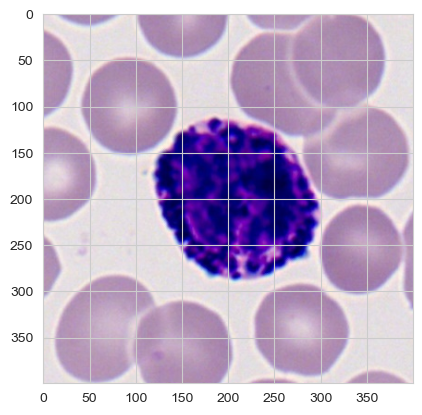

In [18]:
im = cv2.imread("../Data/Munich_sample/BA/BAS_0009.png", cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)


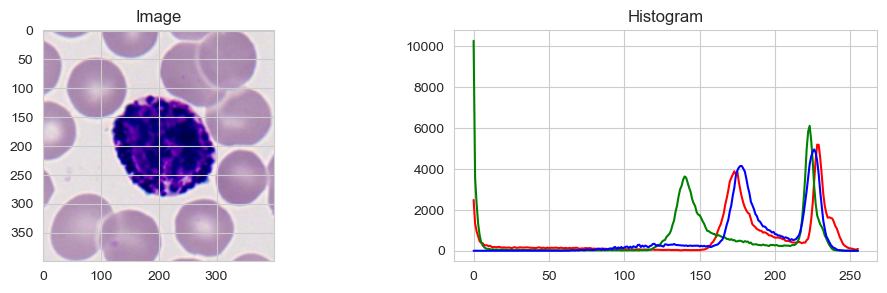

In [14]:
def histogramOpenCV(_img):
    _, axis = plt.subplots(ncols=2, figsize=(12, 3))
    axis[0].imshow(_img)
    axis[1].set_title('Histogram')
    axis[0].set_title('Image')
    colors = ['red', 'green', 'blue']
    for i, col in enumerate(colors):
        histr = cv2.calcHist([_img], [i], None, [256], [0, 256])
        axis[1].plot(histr, color=col)


histogramOpenCV(im)
